# Sample code for APPL stock price prediction - Using 2 features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential # Import Sequential
import zipfile # Import the zipfile module
import io
from sklearn.model_selection import train_test_split
from google.colab import drive

In [ ]:
!pip install nbconvert
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Checkpoint_9.ipynb"

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Update paths to point to your Drive location
nasdaq_zip_path = "/content/drive/My Drive/data_nasdaq_csv.zip"
sp500_zip_path = "/content/drive/My Drive/archive.zip"

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to pdf --"/content/drive/MyDrive/Colab Notebooks/Checkpoint_9.pdf" "/content/drive/MyDrive/Colab Notebooks/Checkpoint_9.ipynb"

[NbConvertApp] WARNING | pattern '--/content/drive/MyDrive/Colab Notebooks/Checkpoint_9.pdf' matched no files
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Checkpoint_9.ipynb to pdf
[NbConvertApp] Support files will be in Checkpoint_9_files/
[NbConvertApp] Making directory ./Checkpoint_9_files
[NbConvertApp] Writing 214586 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1517034 bytes to /content/drive/MyDrive/Colab Notebooks/Checkpoint_9.pdf


In [ ]:
# Initialize dictionaries
stock_data = {}
sp500_data = {}

# Load Nasdaq data
with zipfile.ZipFile('/content/drive/MyDrive/data_nasdaq_csv.zip', 'r') as zip_ref:
    for filename in zip_ref.namelist():
        if filename.startswith('__MACOSX') or filename.startswith('.'):
            continue

        if filename.endswith('.csv'):
            with zip_ref.open(filename) as file:
                stock_symbol = filename.split('.')[0]
                if '/' in stock_symbol:
                    stock_symbol = stock_symbol.split('/')[-1]
                try:
                    df = pd.read_csv(io.BytesIO(file.read()), encoding='utf-8', on_bad_lines='skip')
                except UnicodeDecodeError:
                    try:
                        df = pd.read_csv(io.BytesIO(file.read()), encoding='latin-1', on_bad_lines='skip')
                    except:
                        continue
                except:
                    continue
                stock_data[stock_symbol] = df

print(f"Loaded data for {len(stock_data)} stocks.")

Loaded data for 1564 stocks.


In [ ]:
# Load S&P 500 data
with zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') as zip_ref:
    with zip_ref.open('sp500_companies.csv') as file:
        sp500_data['companies'] = pd.read_csv(io.BytesIO(file.read()))
    with zip_ref.open('sp500_stocks.csv') as file:
        sp500_data['stocks'] = pd.read_csv(io.BytesIO(file.read()))
    with zip_ref.open('sp500_index.csv') as file:
        sp500_data['index'] = pd.read_csv(io.BytesIO(file.read()))

In [ ]:
# Filtering function
def get_filtered_companies():
    nasdaq_symbols = set(stock_data.keys())
    sp500_symbols = set(sp500_data['companies']['Symbol'].tolist())
    valid_symbols = nasdaq_symbols.intersection(sp500_symbols)

    filtered_companies = []
    min_data_points = 120

    for symbol in valid_symbols:
        df = stock_data[symbol]
        if len(df) >= min_data_points:
            filtered_companies.append(symbol)

    print(f"Found {len(filtered_companies)} companies that are in both Nasdaq and S&P 500")
    return filtered_companies

# Get filtered companies
filtered_symbols = get_filtered_companies()

Found 115 companies that are in both Nasdaq and S&P 500


In [ ]:
# Select target stock and get peer companies
symbol = 'AAPL'
if symbol in filtered_symbols:
    company_info = sp500_data['companies'][sp500_data['companies']['Symbol'] == symbol]

    company_sector = company_info['Sector'].iloc[0]
    company_industry = company_info['Industry'].iloc[0]
    company_marketcap = company_info['Marketcap'].iloc[0]

    sector_peers = sp500_data['companies'][
        (sp500_data['companies']['Sector'] == company_sector) &
        (sp500_data['companies']['Symbol'] != symbol) &
        (sp500_data['companies']['Symbol'].isin(filtered_symbols))
    ].sort_values('Marketcap', ascending=False)

    peer_companies = sector_peers['Symbol'].tolist()[:3]

    print(f"\nAnalyzing {symbol}")
    print(f"Sector: {company_sector}")
    print(f"Industry: {company_industry}")
    print(f"Market Cap: ${company_marketcap:,.2f}")
    print(f"Selected peers: {peer_companies}")


Analyzing AAPL
Sector: Technology
Industry: Consumer Electronics
Market Cap: $3,430,681,935,872.00
Selected peers: ['NVDA', 'MSFT', 'AMD']


In [ ]:
### Split the dataset into time windows to get data samples.

df= stock_data[symbol]
X_data = []
y_data = []
label_index = 2 # Open price as label (index 2)
window_size=30 # Time window for data feature (size of 'number of days').


# Only get the open price (index 2 in the data frame)
for i in range(0, len(df) - window_size - 1):
    data_feature = [] # Number of day samples (window_size)
    data_label = []

    # Get a window_size time frame for data features
    for j in range(window_size):
        features = [] # Features per day sample
        features.append(df.iloc[i + j, 1]) # Add low price feature (index 1)
        features.append(df.iloc[i + j, 2])
        features.append(df.iloc[i + j, 3])
        features.append(df.iloc[i + j, 4])
        features.append(df.iloc[i + j, 5]) # Add open price feature (index 5)
        features.append(df.iloc[i + j, 6])
        # Group features to form a data sample
        data_feature.append(features)

    # Next value is the label (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, label_index]) # Add open price as label (label_index = 2)

    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 6))
    y_data.append(np.array(data_label))

In [ ]:
### Split the data into training, validation and test set

# Import the library
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 6)
X_val = X_val.reshape(X_val.shape[0], window_size, 6)
X_test = X_test.reshape(X_test.shape[0], window_size, 6)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (6757, 30, 6)
Shape of validation set:  (1690, 30, 6)
Shape of test set:  (2112, 30, 6)


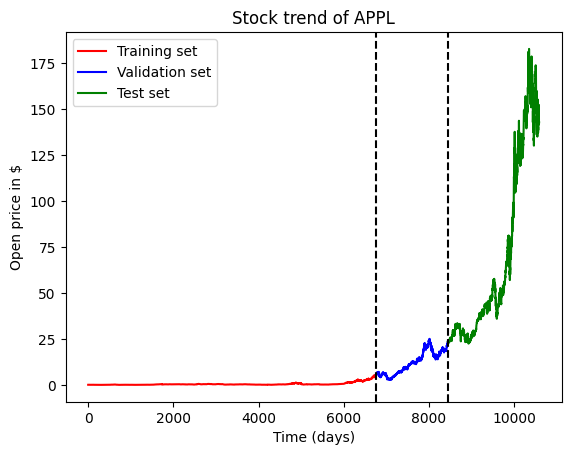

In [ ]:
# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

# Plot the subset splits
ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title("Stock trend of APPL")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
##########
### MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
##########
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()

for i in range(0, len(X_train)):
    min_feature_label = -sys.maxsize -1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_train[0][0])): # len(X_train[0][0]): number of time-series features used

        # Calculate min and max to normlaize features x
        min_feature = np.min(X_train[i][:,j]) # Get min value to normalize feature x[j]
        max_feature = np.max(X_train[i][:,j]) # Get max value to normalize feature x[j]
        X_train_norm[i][:,j] = (X_train[i][:,j] - min_feature) / (max_feature - min_feature) # Normalize feature x[j]

    # Calculate min and max to normlaize label y
    min_feature_label = np.min(X_train[i][:,label_index - 1]) # Get min value to normalize label y
    max_feature_label = np.max(X_train[i][:,label_index - 1]) # Get max value to normalize label y
    y_train_norm[i] = (y_train[i] - min_feature_label) / (max_feature_label - min_feature_label) # Normalize label y


##########
### MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
##########
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature_label = -sys.maxsize -1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_val[0][0])): # len(X_val[0][0]): number of time-series features used

        # Calculate min and max to normlaize features x
        min_feature = np.min(X_val[i][:,j]) # Get min value to normalize feature x[j]
        max_feature = np.max(X_val[i][:,j]) # Get max value to normalize feature x[j]
        X_val_norm[i][:,j] = (X_val[i][:,j] - min_feature) / (max_feature - min_feature) # Normalize feature x[j]

    # Calculate min and max to normlaize label y
    min_feature_label = np.min(X_val[i][:,label_index - 1]) # Get min value to normalize label y
    max_feature_label = np.max(X_val[i][:,label_index - 1]) # Get max value to normalize label y
    y_val_norm[i] = (y_val[i] - min_feature_label) / (max_feature_label - min_feature_label) # Normalize label y

# Time-series data with LSTM

In [ ]:
### Create and train the model
import tensorflow as tf
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense

# Build the model architecture
model = tf.keras.Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(window_size,len(features))))
model.add(LSTM(units=64))
model.add(Dense(100, activation='relu'))
model.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

model_checkpoint = ModelCheckpoint(
    f'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( # Use keras.callbacks to access ReduceLROnPlateau
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)
# Compile and train the model with Mean Squared Error loss function
model.summary()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=30, batch_size=512, callbacks=[early_stopping, model_checkpoint, reduce_lr])

# Calculate the number of parameters of each layer
# LSTM_1: input_dim = 2, output_dim = 32 --> 4*(2*32+32*32+32) = 4,480 params.
# LSTM_2: input_dim = 32, output_dim = 64 --> 4*(32*64+64*64+64) = 24,832 params
# Dense(100) = (64+1)*100 = 6,500 params.
# Dense(1) = (100+1)*1 = 101 params.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 32)              │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,425 (142.29 KB)

 Trainable params: 36,425 (142.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2570 - mse: 0.2570
Epoch 1: val_loss improved from inf to 0.04703, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.2273 - mse: 0.2273 - val_loss: 0.0470 - val_mse: 0.0470 - learning_rate: 0.0100
Epoch 2/30
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0449 - mse: 0.0449
Epoch 2: val_loss improved from 0.04703 to 0.02264, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0226 - val_mse: 0.0226 - learning_rate: 0.0100
Epoch 3/30
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0237 - mse: 0.0237
Epoch 3: val_loss did not improve from 0.02264
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0237 - val_mse: 0.0237 - learning_rate: 0.0100
Epoch 4/30
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - mse: 0.0181
Epoch 4: val_loss improved from 0.02264 to 0.01725, saving model to best_model.

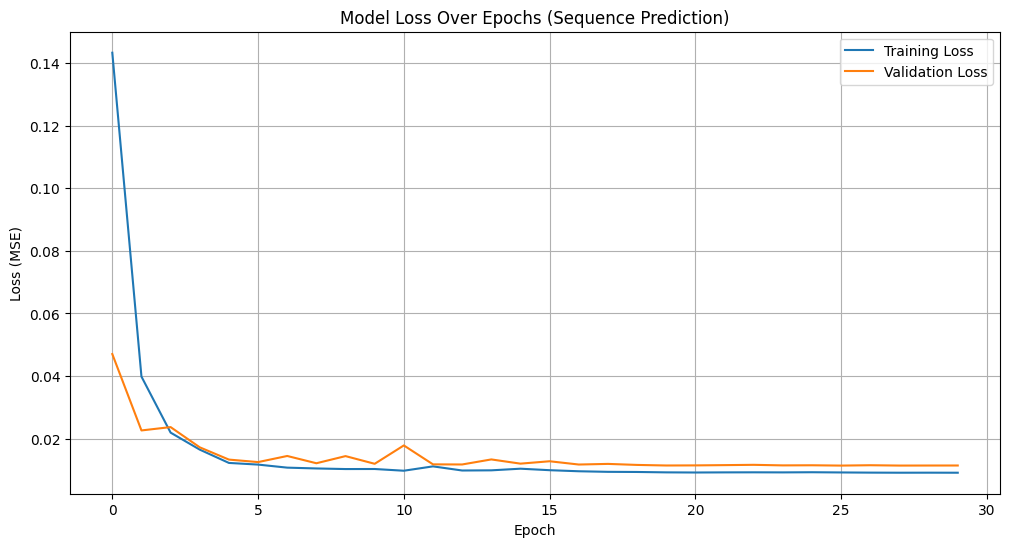

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs (Sequence Prediction)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
##########
### MinMax normalize the test data: x=(x-min(x)/(max(x)-min(x))
##########
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature_label = -sys.maxsize -1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_test[0][0])): # len(X_test[0][0]): number of time-series features used

        # Calculate min and max to normlaize features x
        min_feature = np.min(X_test[i][:,j]) # Get min value to normalize feature x[j]
        max_feature = np.max(X_test[i][:,j]) # Get max value to normalize feature x[j]
        X_test_norm[i][:,j] = (X_test[i][:,j] - min_feature) / (max_feature - min_feature) # Normalize feature x[j]

    # Calculate min and max to normlaize label y
    min_feature_label = np.min(X_test[i][:,label_index - 1]) # Get min value to normalize label y
    max_feature_label = np.max(X_test[i][:,label_index - 1]) # Get max value to normalize label y
    y_test_norm[i] = (y_test[i] - min_feature_label) / (max_feature_label - min_feature_label) # Normalize label y

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
test_mse = mean_squared_error(y_pred_norm, y_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE on the test set:  0.011938806672014163


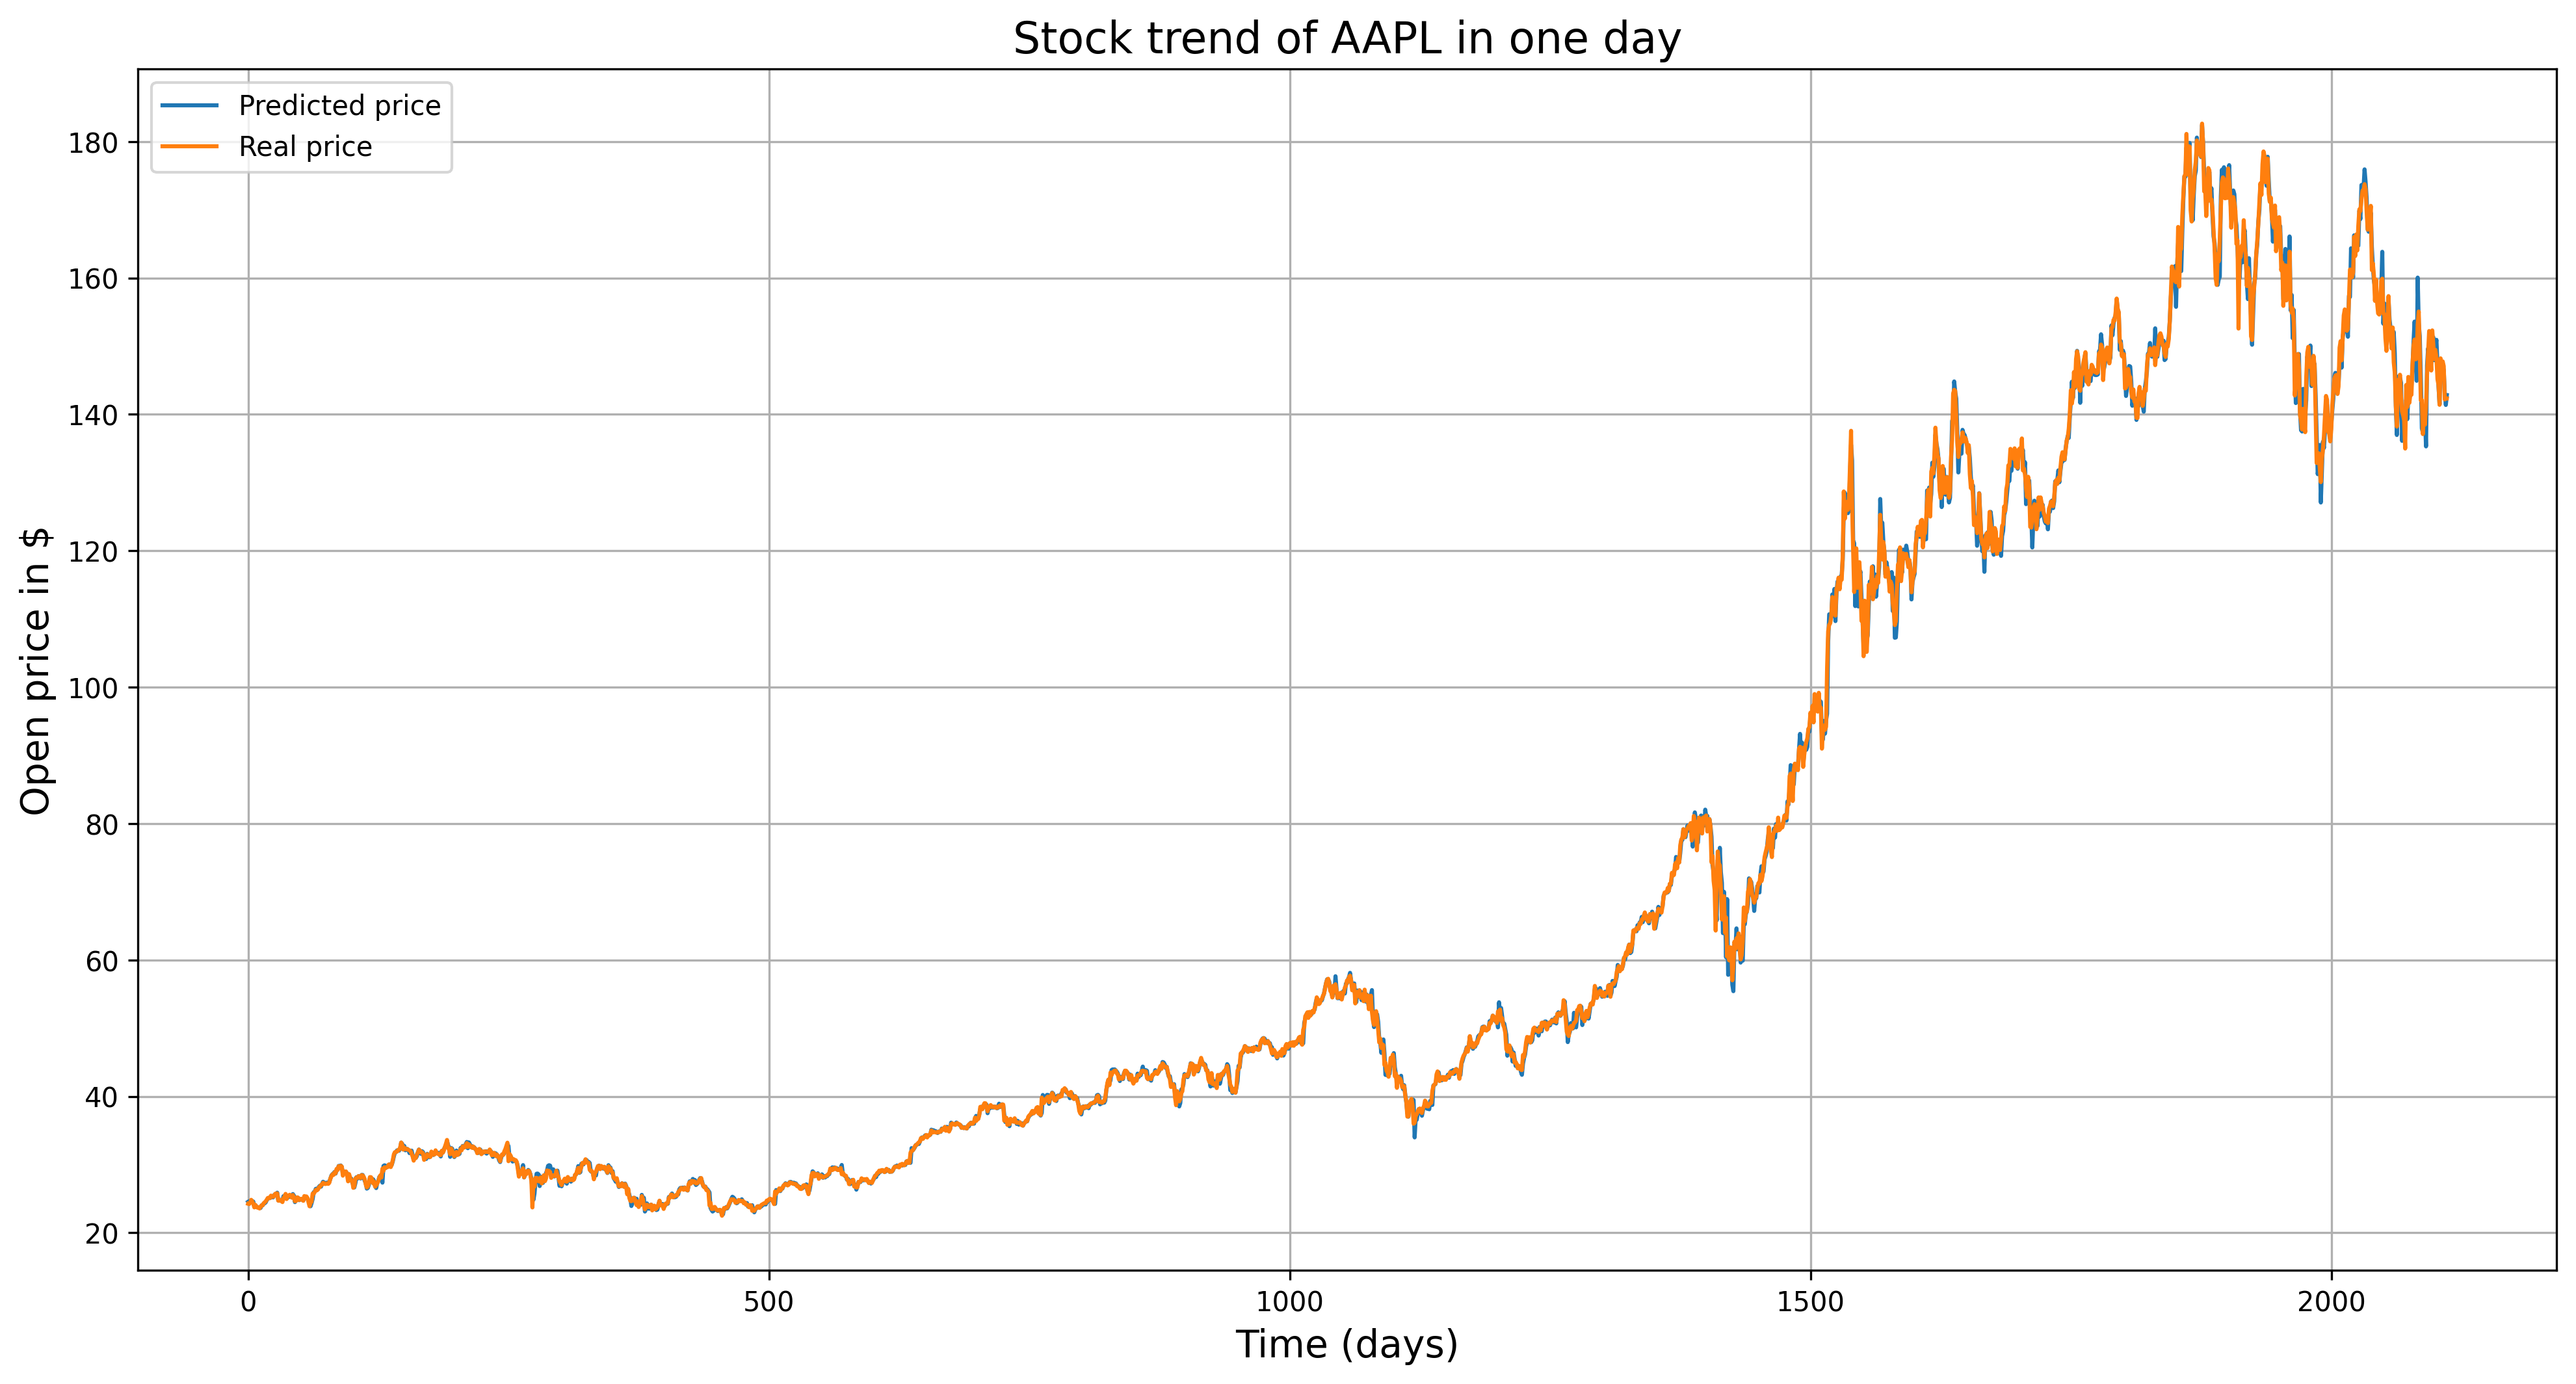

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm.copy()
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature_label = np.min(X_test[i][:,label_index - 1]) # Get min value to de-normalize label y
    max_feature_label = np.max(X_test[i][:,label_index - 1]) # Get max value to de-normalize label y
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature_label - min_feature_label) + min_feature_label # De-normalize label y

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title(f'Stock trend of {symbol} in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

In [ ]:
# Save the model with test MSE in filename
model_filename = f'model_test_mse_one_day{test_mse:.6f}.keras'
model.save(model_filename)
print(f'\nModel saved as: {model_filename}')


Model saved as: model_test_mse_one_day0.007800.keras


# **Nasdaq k-day Prediction**

In [ ]:
target_symbol = 'AAPL'
df_k = stock_data[target_symbol]
X_k_data = []
y_k_data = []
label_index = 2  # Open price as label (index 2)
window_size = 30  # Time window for data feature (size of 'number of days')
k = 25  # Predict the kth day ahead (e.g., 3rd day)

# Only get the open price (index 2 in the data frame)
for i in range(0, len(df) - window_size - k):  # Modified range to account for kth day prediction
    data_k_feature = []  # Number of day samples (window_size)
    data_k_label = []

    # Get a window_size time frame for data features
    for j in range(window_size):
        features = []  # Features per day sample
        features.append(df.iloc[i + j, 1])  # Add low price feature (index 1)
        features.append(df.iloc[i + j, 2])
        features.append(df.iloc[i + j, 3])
        features.append(df.iloc[i + j, 4])
        features.append(df.iloc[i + j, 5])
        features.append(df.iloc[i + j, 6])
        # Group features to form a data sample
        data_k_feature.append(features)

    # kth value is the label (price of the kth day) to be predicted
    data_k_label.append(df_k.iloc[i + window_size + k - 1, label_index])  # Modified to get kth day price

    # Append new data sample (feature and label) to X_data and y_data
    X_k_data.append(np.array(data_k_feature).reshape(window_size, 6))
    y_k_data.append(np.array(data_k_label))

In [ ]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k_data, y_k_data, test_size=0.2, shuffle=False)
X_train_k, X_val_k, y_train_k, y_val_k = train_test_split(X_train_k, y_train_k, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train_k = np.array(X_train_k)
X_val_k = np.array(X_val_k)
X_test_k = np.array(X_test_k)
y_train_k = np.array(y_train_k)
y_val_k = np.array(y_val_k)
y_test_k = np.array(y_test_k)

# Reshape the numpy array to fit the neural network input shape requirement
X_train_k = X_train_k.reshape(X_train_k.shape[0], window_size, 6)
X_val_k = X_val_k.reshape(X_val_k.shape[0], window_size, 6)
X_test_k = X_test_k.reshape(X_test_k.shape[0], window_size, 6)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train_k.shape)
print("Shape of validation set: ", X_val_k.shape)
print("Shape of test set: ", X_test_k.shape)

Shape of training set:  (6742, 30, 6)
Shape of validation set:  (1686, 30, 6)
Shape of test set:  (2107, 30, 6)


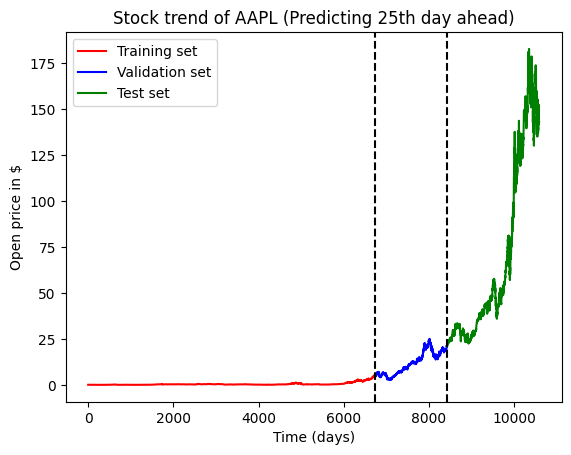

In [ ]:
# Visualize the training, validation and test set
df_k_plot = df_k['Open']
df_k_plot = df_k_plot.reset_index(drop=False)

# Get lengths of the three subsets
size_train_k = X_train_k.shape[0]
size_val_k = X_val_k.shape[0]
size_test_k = X_test_k.shape[0]

# Plot the subset splits
ax = df_k_plot.iloc[:size_train_k,1:2].plot(y=0, color='red', label='Training set')
df_k_plot.iloc[size_train_k:size_train_k+size_val_k,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_k_plot.iloc[size_train_k+size_val_k:df_k_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title(f"Stock trend of {target_symbol} (Predicting {k}th day ahead)")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train_k, color='black', linestyle='--')
plt.axvline(x=size_train_k+size_val_k, color='black', linestyle='--')
plt.show()

In [ ]:
### MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
##########
X_train_norm_k = X_train_k.copy()
y_train_norm_k = y_train_k.copy()

for i in range(0, len(X_train_k)):
    min_feature_label_k = -sys.maxsize -1
    max_feature_label_k = sys.maxsize
    for j in range(0, len(X_train_k[0][0])):  # len(X_train[0][0]): number of time-series features used

        # Calculate min and max to normlaize features x
        min_feature_k = np.min(X_train_k[i][:,j])  # Get min value to normalize feature x[j]
        max_feature_k = np.max(X_train_k[i][:,j])  # Get max value to normalize feature x[j]
        X_train_norm_k[i][:,j] = (X_train_k[i][:,j] - min_feature_k) / (max_feature_k - min_feature_k)  # Normalize feature x[j]

    # Calculate min and max to normlaize label y
    min_feature_label_k = np.min(X_train_k[i][:,label_index - 1])  # Get min value to normalize label y
    max_feature_label_k = np.max(X_train_k[i][:,label_index - 1])  # Get max value to normalize label y
    y_train_norm_k[i] = (y_train_k[i] - min_feature_label_k) / (max_feature_label_k - min_feature_label_k)  # Normalize label y


##########
### MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
##########
X_val_norm_k = X_val_k.copy()
y_val_norm_k = y_val_k.copy()
for i in range(0, len(X_val_k)):
    min_feature_label_k = -sys.maxsize -1
    max_feature_label_k = sys.maxsize
    for j in range(0, len(X_val_k[0][0])):  # len(X_val[0][0]): number of time-series features used

        # Calculate min and max to normlaize features x
        min_feature_k = np.min(X_val_k[i][:,j])  # Get min value to normalize feature x[j]
        max_feature_k = np.max(X_val_k[i][:,j])  # Get max value to normalize feature x[j]
        X_val_norm_k[i][:,j] = (X_val_k[i][:,j] - min_feature_k) / (max_feature_k - min_feature_k)  # Normalize feature x[j]

    # Calculate min and max to normlaize label y
    min_feature_label_k = np.min(X_val_k[i][:,label_index - 1])  # Get min value to normalize label y
    max_feature_label_k = np.max(X_val_k[i][:,label_index - 1])  # Get max value to normalize label y
    y_val_norm_k[i] = (y_val_k[i] - min_feature_label_k) / (max_feature_label_k - min_feature_label_k)  # Normalize label y

In [ ]:
### Create and train the model
import tensorflow as tf
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense

# Build the model architecture
model_k = tf.keras.Sequential()
model_k.add(LSTM(units=32, return_sequences=True, input_shape=(window_size,6)))
model_k.add(LSTM(units=64))
model_k.add(Dense(100, activation='relu'))
model_k.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

model_checkpoint_k = ModelCheckpoint(
    f'best_model_k.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( # Use keras.callbacks to access ReduceLROnPlateau
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)
# Compile and train the model with Mean Squared Error loss function
model_k.summary()
model_k.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_k = model_k.fit(X_train_norm_k, y_train_norm_k, validation_data=(X_val_norm_k,y_val_norm_k), epochs=30, batch_size=512, callbacks=[early_stopping, model_checkpoint_k, reduce_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 32)              │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,425 (142.29 KB)

 Trainable params: 36,425 (142.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3556 - mse: 1.3556
Epoch 1: val_loss improved from inf to 0.84734, saving model to best_model_k.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.2792 - mse: 1.2792 - val_loss: 0.8473 - val_mse: 0.8473 - learning_rate: 0.0100
Epoch 2/30
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8849 - mse: 0.8849
Epoch 2: val_loss improved from 0.84734 to 0.72639, saving model to best_model_k.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8806 - mse: 0.8806 - val_loss: 0.7264 - val_mse: 0.7264 - learning_rate: 0.0100
Epoch 3/30
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8398 - mse: 0.8398
Epoch 3: val_loss improved from 0.72639 to 0.70532, saving model to best_model_k.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8383 - mse: 0.8383 - val_loss: 0.7053 - val_mse: 0.7053 - learning_rate: 0.0100
Epoch 4/30
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7909 - mse: 0.7909
Epoch 4: val_loss improved from 0

In [ ]:
### MinMax normalize the test data: x=(x-min(x)/(max(x)-min(x))
##########
X_test_norm_k = X_test_k.copy()
y_test_norm_k = y_test_k.copy()
for i in range(0, len(X_test_k)):
    min_feature_label_k = -sys.maxsize -1
    max_feature_label_k = sys.maxsize
    for j in range(0, len(X_test_k[0][0])):  # len(X_test[0][0]): number of time-series features used

        # Calculate min and max to normlaize features x
        min_feature_k = np.min(X_test_k[i][:,j])  # Get min value to normalize feature x[j]
        max_feature_k = np.max(X_test_k[i][:,j])  # Get max value to normalize feature x[j]
        X_test_norm_k[i][:,j] = (X_test_k[i][:,j] - min_feature_k) / (max_feature_k - min_feature_k)  # Normalize feature x[j]

    # Calculate min and max to normlaize label y
    min_feature_label_k = np.min(X_test_k[i][:,label_index - 1])  # Get min value to normalize label y
    max_feature_label_k = np.max(X_test_k[i][:,label_index - 1])  # Get max value to normalize label y
    y_test_norm_k[i] = (y_test_k[i] - min_feature_label_k) / (max_feature_label_k - min_feature_label_k)  # Normalize label y

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm_k = model_k.predict(X_test_norm_k)
test_mse_k = mean_squared_error(y_pred_norm_k, y_test_norm_k)
print(f"MSE on the test set (predicting {k}th day ahead): ", mean_squared_error(y_pred_norm_k, y_test_norm_k))

# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm_k = y_pred_norm_k.copy()
for i in range(0, len(y_pred_denorm_k)):  # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature_label_k = np.min(X_test_k[i][:,label_index - 1])  # Get min value to de-normalize label y
    max_feature_label_k = np.max(X_test_k[i][:,label_index - 1])  # Get max value to de-normalize label y
    y_pred_denorm_k[i] = y_pred_norm_k[i] * (max_feature_label_k - min_feature_label_k) + min_feature_label_k  # De-normalize label y

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE on the test set (predicting 25th day ahead):  0.7762638925634665


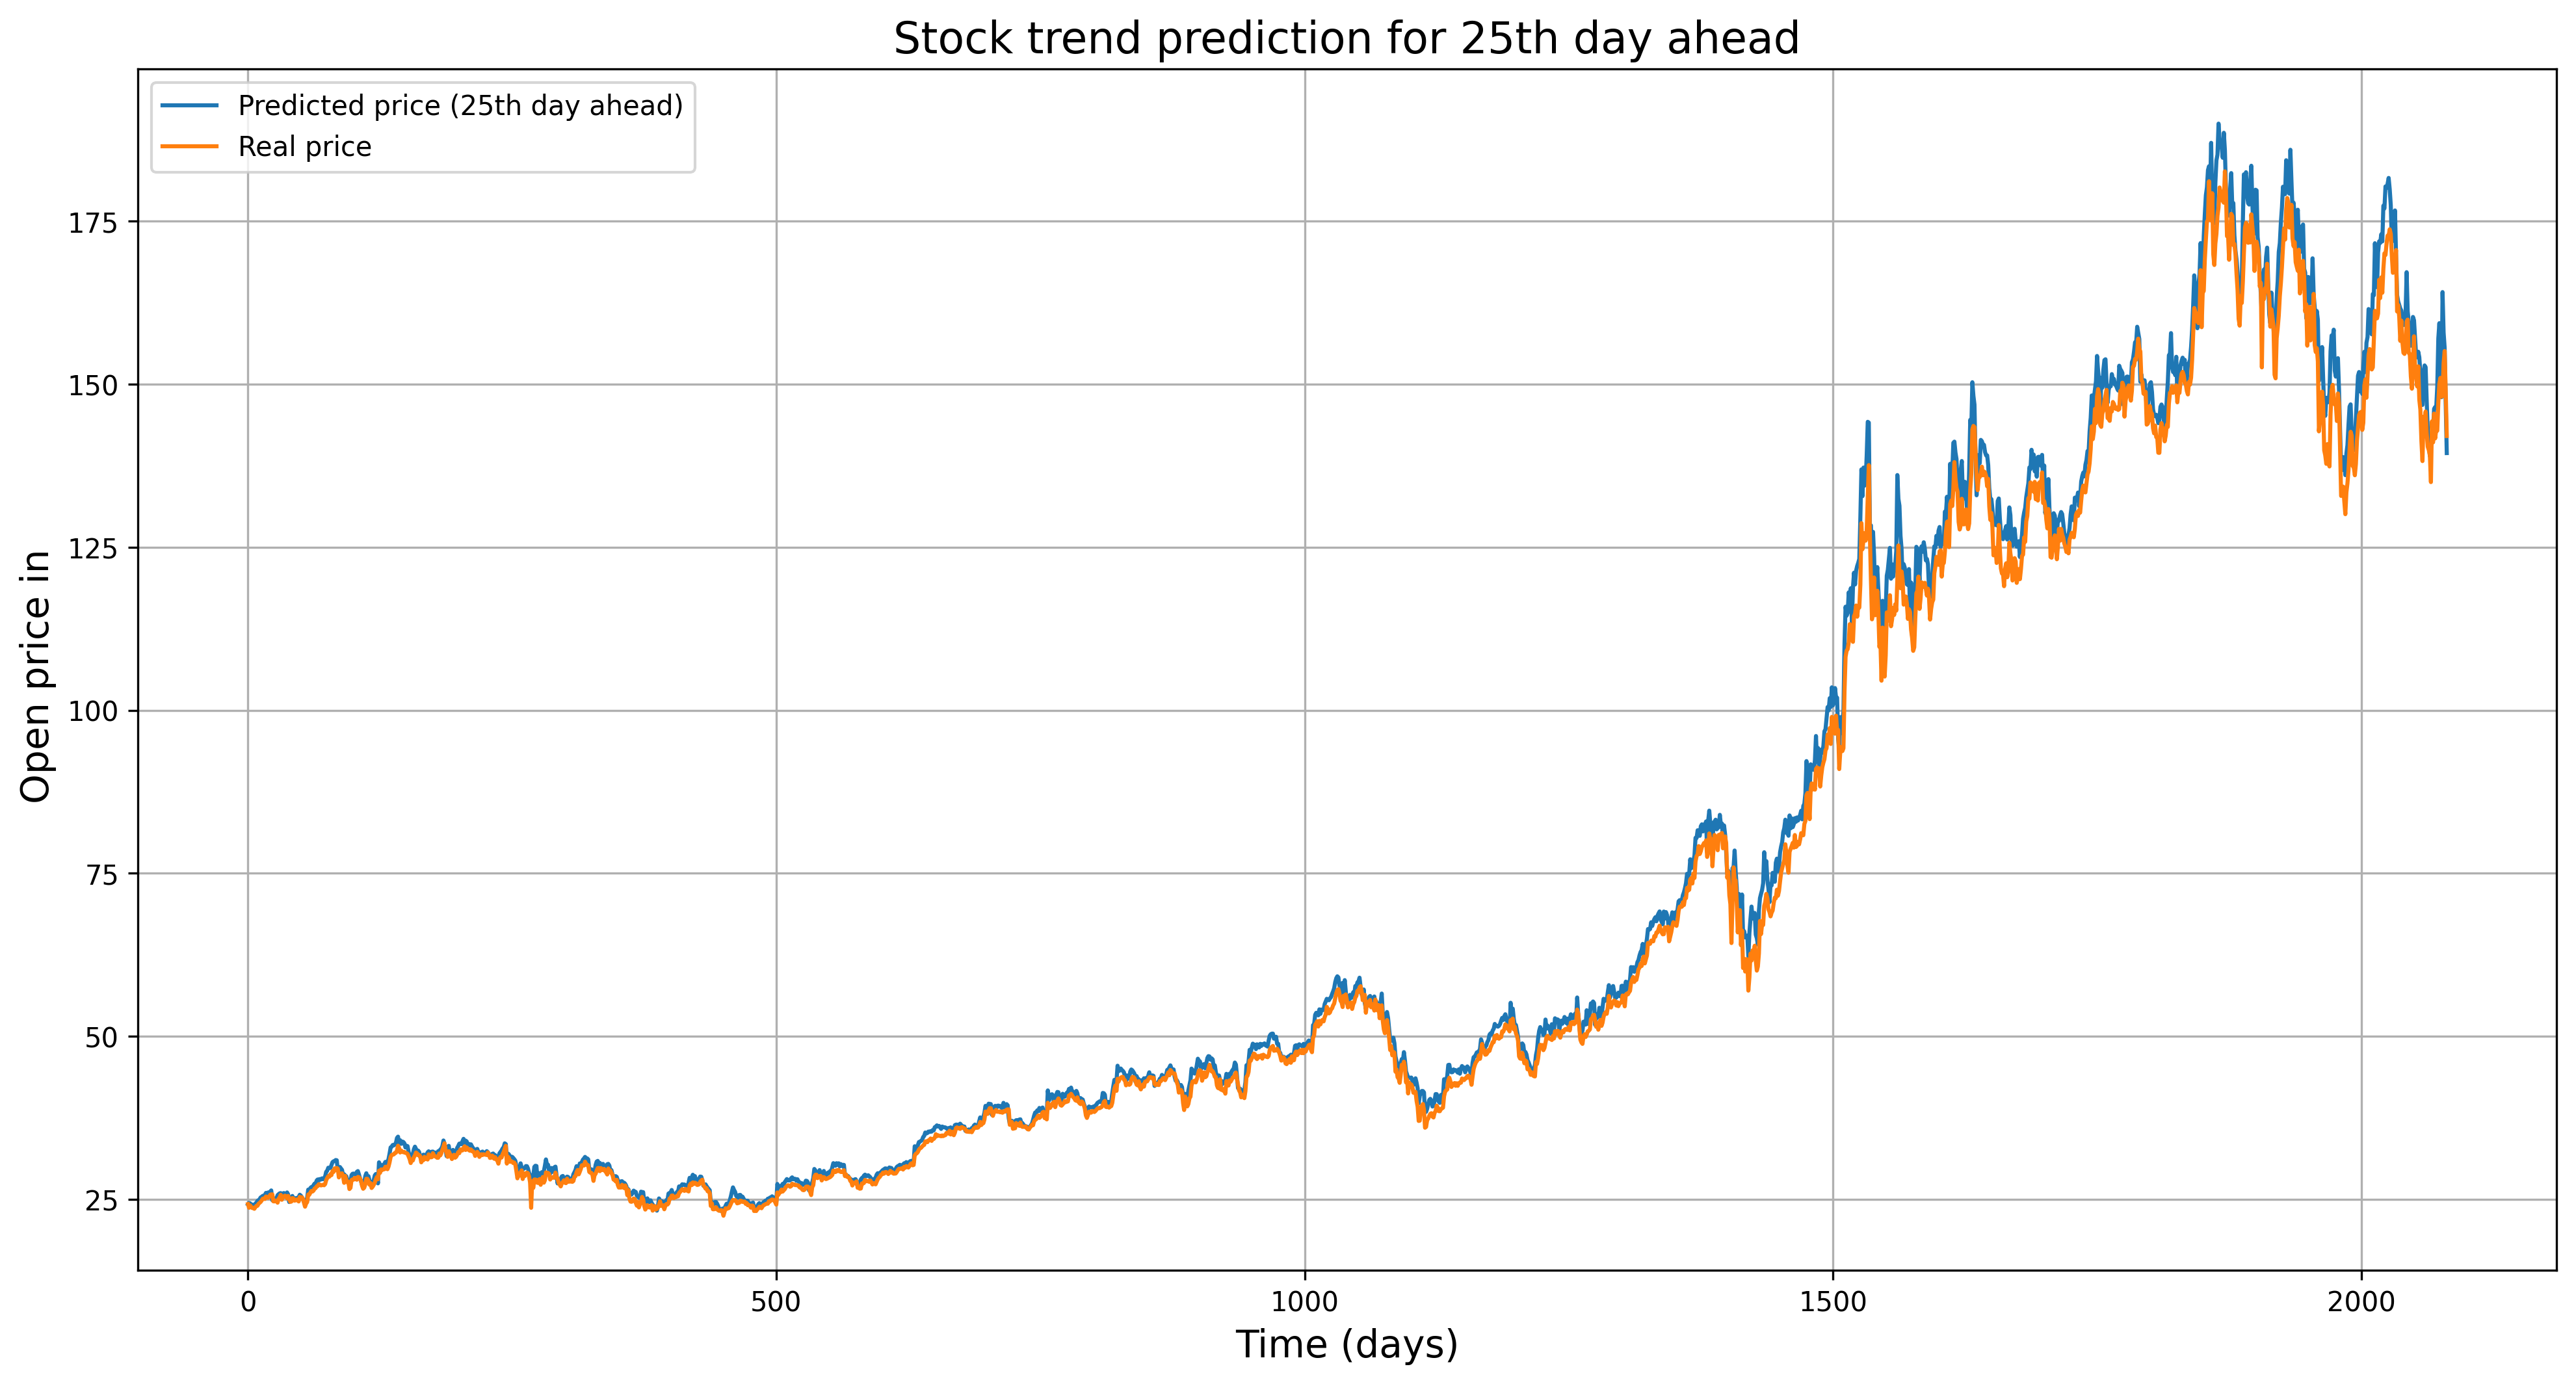

In [ ]:
# Visualize predicted stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)

# Create time indices for proper alignment
# Adjust time_index to match the length of the shifted data
time_index = np.arange(len(y_test_k) - k) # Change here to match length of y data

# Plot predicted values shifted forward by k days
plt.plot(time_index, y_pred_denorm_k[k:], label=f'Predicted price ({k}th day ahead)')
plt.plot(time_index, y_test_k[:-k], label='Real price')
plt.title(f'Stock trend prediction for {k}th day ahead', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in ', fontsize=14) # Assuming you had a typo here and intended to complete the label
plt.grid()  # Add grid
plt.legend()  # Add legend
plt.show()

In [ ]:
# Save the model with test MSE in filename
model_filename = f'model_test_mse_k_day{test_mse_k:.6f}.keras'
model.save(model_filename)
print(f'\nModel saved as: {model_filename}')


Model saved as: model_test_mse_k_day0.225900.keras


# **Nasdaq K-consecutive days prediction**

In [ ]:
### Split the dataset into time windows to get data samples.
df = stock_data[target_symbol]
X_data_seq = []
y_data_seq = []
label_index = 2  # Open price as label (index 2)
window_size = 30  # Time window for data feature
k = 25  # Predict k consecutive days ahead

# Only get the open price (index 2 in the data frame)
for i in range(0, len(df) - window_size - k):
    data_feature = []
    data_label = []

    # Get a window_size time frame for data features
    for j in range(window_size):
        features = []
        features.append(df.iloc[i + j, 1])  # Add low price feature (index 1)
        features.append(df.iloc[i + j, 2])
        features.append(df.iloc[i + j, 3])
        features.append(df.iloc[i + j, 4])
        features.append(df.iloc[i + j, 5])
        features.append(df.iloc[i + j, 6])
        data_feature.append(features)

    # Get k consecutive days as labels
    for j in range(k):
        data_label.append(df.iloc[i + window_size + j, label_index])

    X_data_seq.append(np.array(data_feature).reshape(window_size, 6))
    y_data_seq.append(np.array(data_label))

In [ ]:
### Split the data into training, validation and test set
from sklearn.model_selection import train_test_split

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data_seq, y_data_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 6)
X_val = X_val.reshape(X_val.shape[0], window_size, 6)
X_test = X_test.reshape(X_test.shape[0], window_size, 6)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (6742, 30, 6)
Shape of validation set:  (1686, 30, 6)
Shape of test set:  (2107, 30, 6)


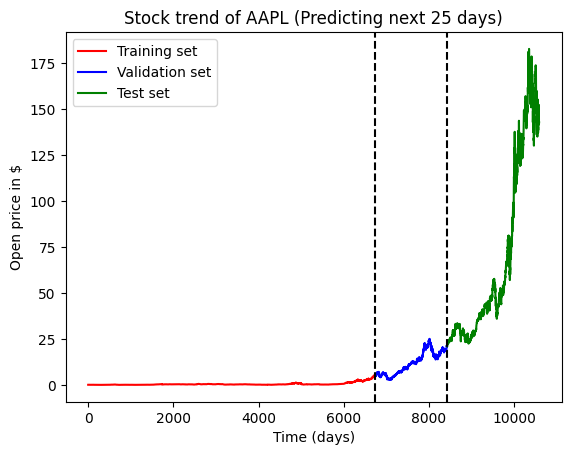

In [ ]:
# Visualize the training, validation and test set
df_plot = df['Open']
df_plot = df_plot.reset_index(drop=False)

size_train = X_train.shape[0]
size_val = X_val.shape[0]
size_test = X_test.shape[0]

ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
ax.set_title(f"Stock trend of {target_symbol} (Predicting next {k} days)")
plt.xlabel('Time (days)')
plt.ylabel('Open price in $')
plt.axvline(x=size_train, color='black', linestyle='--')
plt.axvline(x=size_train+size_val, color='black', linestyle='--')
plt.show()

In [ ]:
### MinMax normalize all data: x=(x-min(x)/(max(x)-min(x))
##########
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()

for i in range(0, len(X_train)):
    min_feature_label = -sys.maxsize -1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_train[0][0])):
        min_feature = np.min(X_train[i][:,j])
        max_feature = np.max(X_train[i][:,j])
        X_train_norm[i][:,j] = (X_train[i][:,j] - min_feature) / (max_feature - min_feature)

    min_feature_label = np.min(X_train[i][:,label_index - 1])
    max_feature_label = np.max(X_train[i][:,label_index - 1])
    for j in range(k):  # Normalize each day's label
        y_train_norm[i][j] = (y_train[i][j] - min_feature_label) / (max_feature_label - min_feature_label)

X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature_label = -sys.maxsize -1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_val[0][0])):
        min_feature = np.min(X_val[i][:,j])
        max_feature = np.max(X_val[i][:,j])
        X_val_norm[i][:,j] = (X_val[i][:,j] - min_feature) / (max_feature - min_feature)

    min_feature_label = np.min(X_val[i][:,label_index - 1])
    max_feature_label = np.max(X_val[i][:,label_index - 1])
    for j in range(k):  # Normalize each day's label
        y_val_norm[i][j] = (y_val[i][j] - min_feature_label) / (max_feature_label - min_feature_label)

X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature_label = -sys.maxsize -1
    max_feature_label = sys.maxsize
    for j in range(0, len(X_test[0][0])):
        min_feature = np.min(X_test[i][:,j])
        max_feature = np.max(X_test[i][:,j])
        X_test_norm[i][:,j] = (X_test[i][:,j] - min_feature) / (max_feature - min_feature)

    min_feature_label = np.min(X_test[i][:,label_index - 1])
    max_feature_label = np.max(X_test[i][:,label_index - 1])
    for j in range(k):  # Normalize each day's label
        y_test_norm[i][j] = (y_test[i][j] - min_feature_label) / (max_feature_label - min_feature_label)


In [ ]:
### Create and train the model
import tensorflow as tf
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense

# Build the model architecture
model_seq = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dense(k, activation='linear')
])

model_checkpoint_seq = ModelCheckpoint(
    f'best_model_seq.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( # Use keras.callbacks to access ReduceLROnPlateau
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)
# Compile and train the model with Mean Squared Error loss function
model_seq.summary()
model_seq.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_seq = model_seq.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs=30, batch_size=512, callbacks=[early_stopping, model_checkpoint_seq, reduce_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 30, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 25)                  │           1,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,681 (526.10 KB)

 Trainable params: 134,681 (526.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0375 - mse: 0.7150
Epoch 1: val_loss improved from inf to 0.52096, saving model to best_model_seq.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 1.0155 - mse: 0.7036 - val_loss: 0.5210 - val_mse: 0.4270 - learning_rate: 0.0100
Epoch 2/30
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5523 - mse: 0.4842
Epoch 2: val_loss did not improve from 0.52096
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5494 - mse: 0.4838 - val_loss: 0.5348 - val_mse: 0.5164 - learning_rate: 0.0100
Epoch 3/30
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4944 - mse: 0.4793
Epoch 3: val_loss improved from 0.52096 to 0.37154, saving model to best_model_seq.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4912 - mse: 0.4766 - val_loss: 0.3715 - val_mse: 0.3619 - learning_rate: 0.0100
Epoch 4/30
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4390 - mse: 0.4299
Epoch 4: val_loss improved from 0.37154 to 0.34368, saving model to b

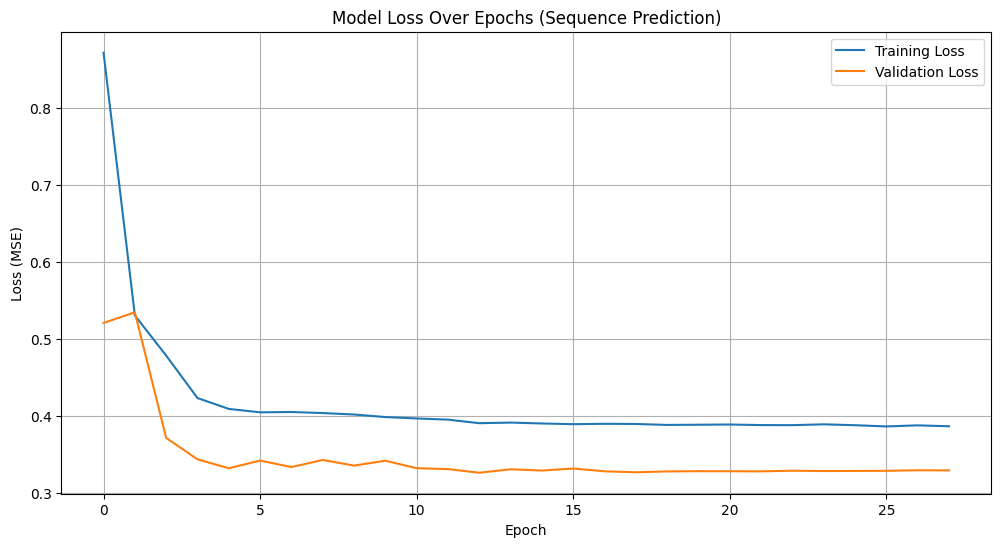

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_seq.history['loss'], label='Training Loss')
plt.plot(history_seq.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs (Sequence Prediction)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### Get prediction and de-normalize
from sklearn.metrics import mean_squared_error

y_pred_norm = model_seq.predict(X_test_norm)
print(f"MSE on the test set (predicting next {k} days): ", mean_squared_error(y_pred_norm, y_test_norm))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MSE on the test set (predicting next 25 days):  0.36325438805944954


In [ ]:
# De-normalize predictions
y_pred_denorm = y_pred_norm.copy()
for i in range(0, len(y_pred_denorm)):
    min_feature_label = np.min(X_test[i][:,label_index - 1])
    max_feature_label = np.max(X_test[i][:,label_index - 1])
    for j in range(k):  # De-normalize each day's prediction
        y_pred_denorm[i][j] = y_pred_norm[i][j] * (max_feature_label - min_feature_label) + min_feature_label

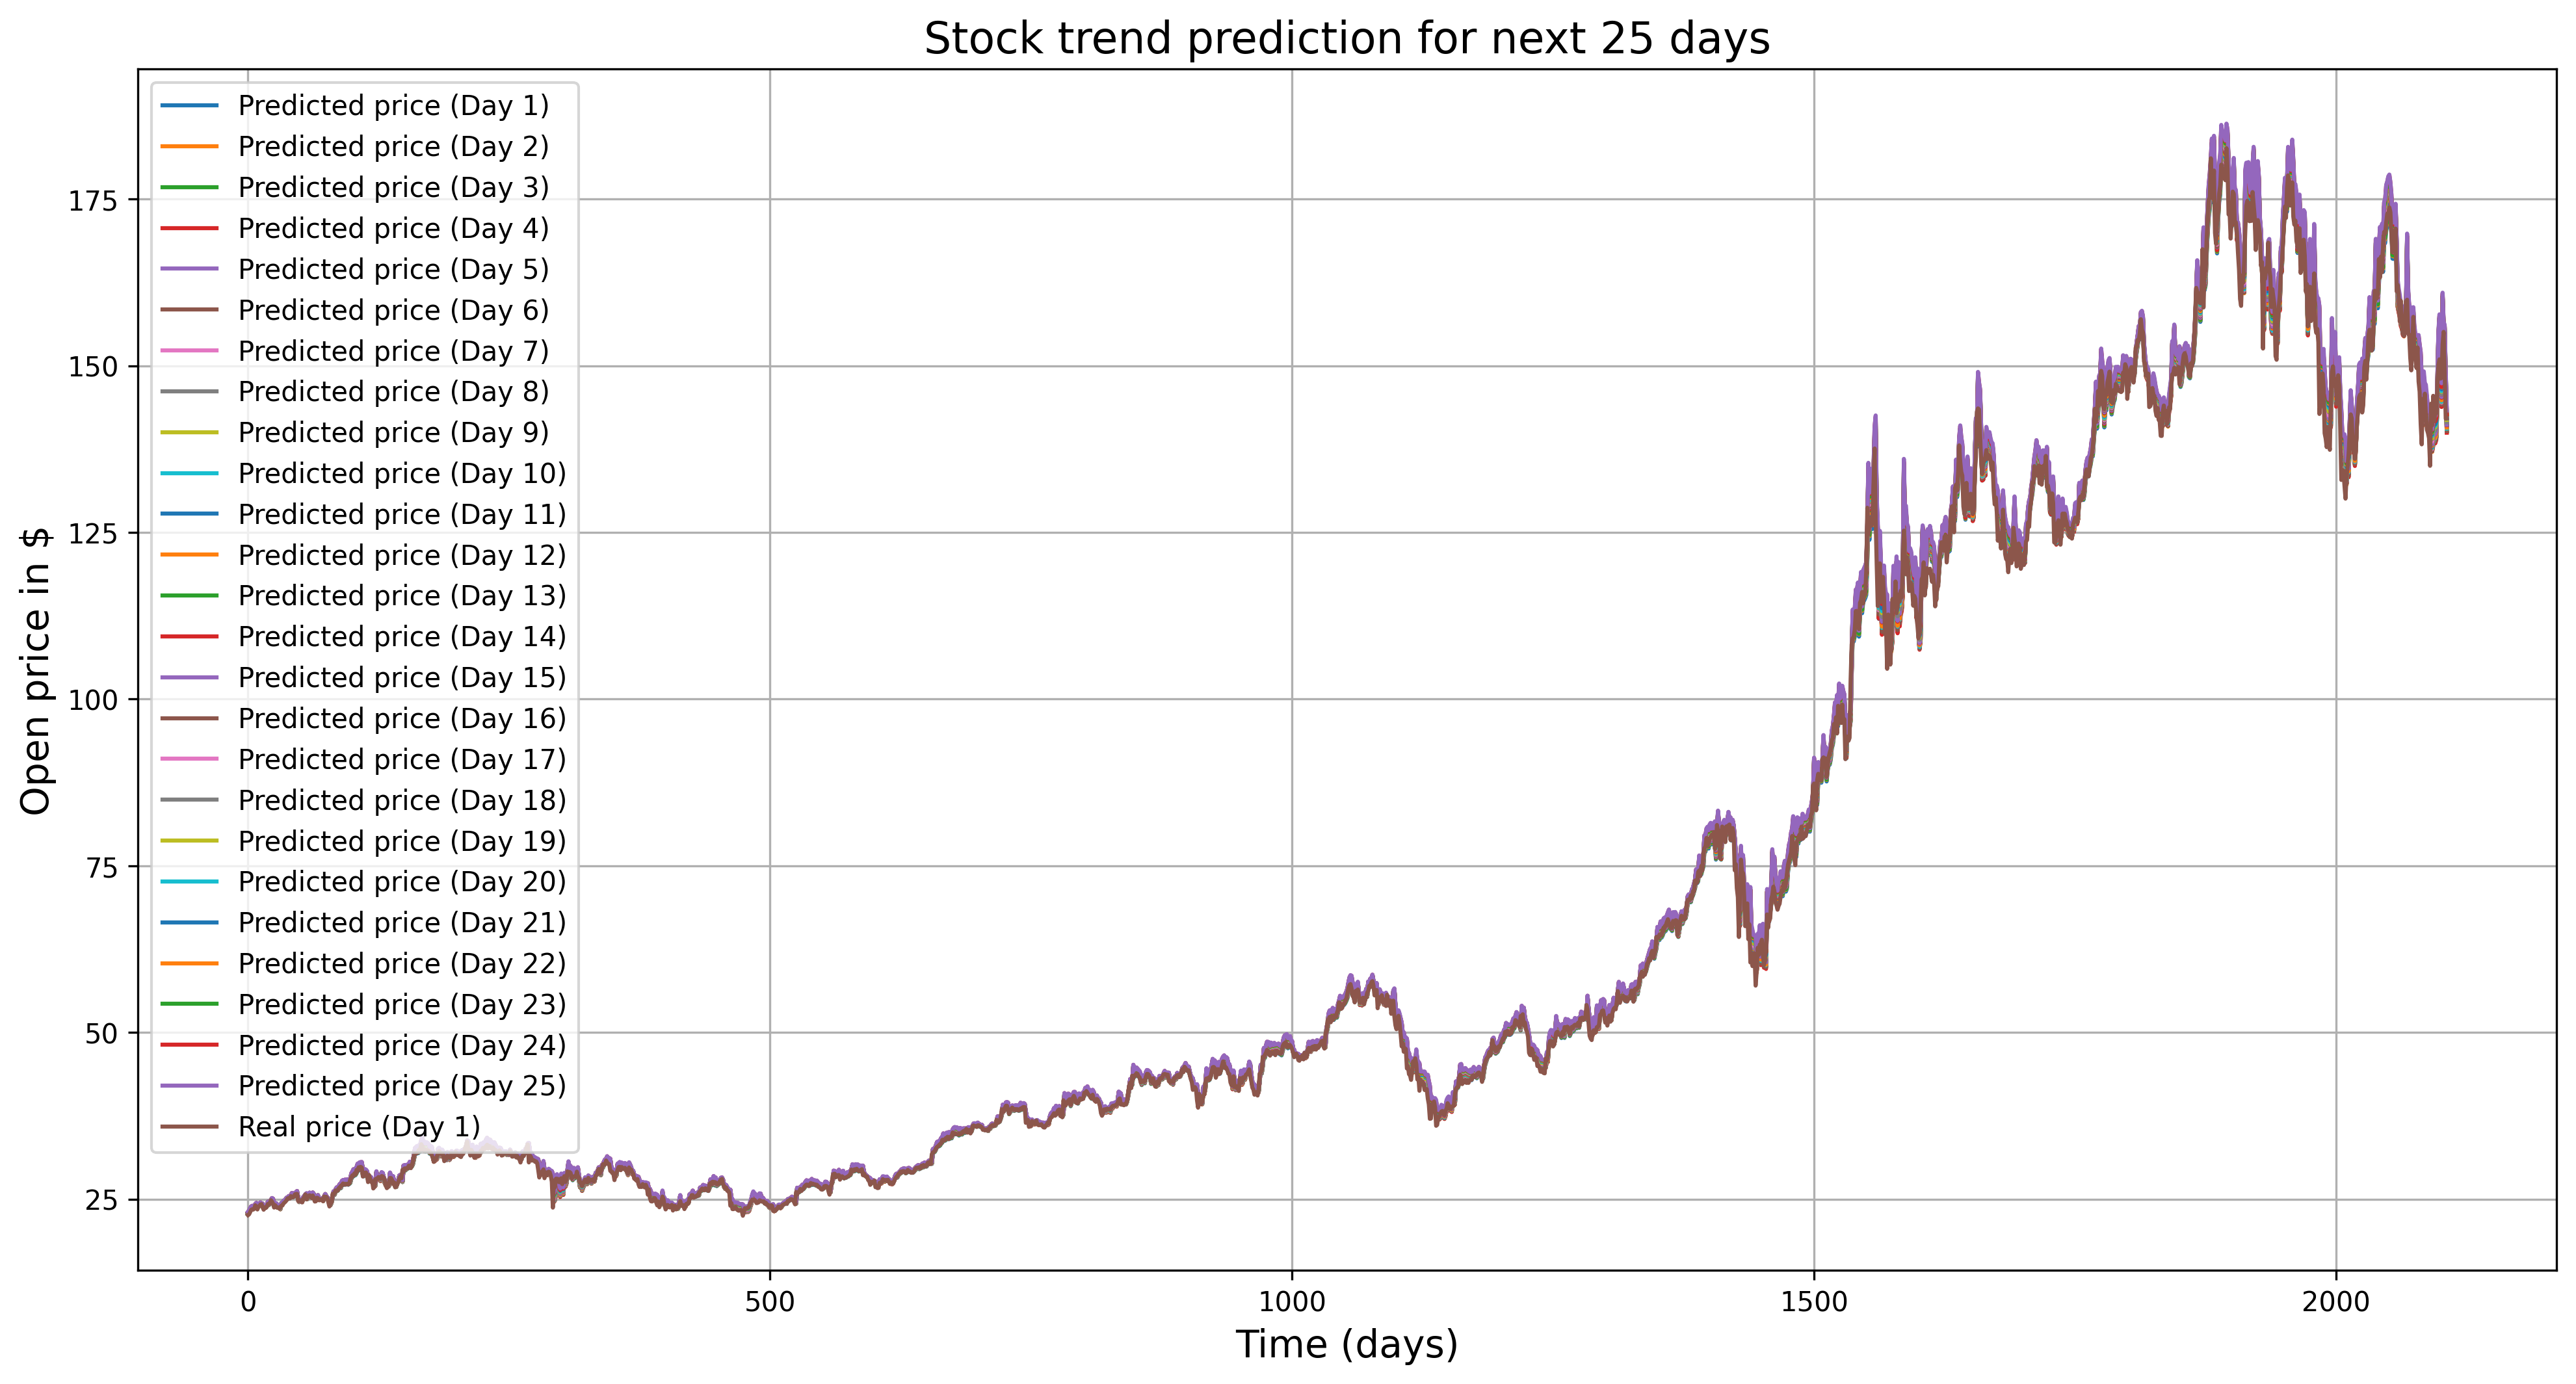

In [ ]:
# Visualize predictions for each day
plt.figure(figsize=(16, 8), dpi=300)
for day in range(k):
    plt.plot(y_pred_denorm[:,day], label=f'Predicted price (Day {day+1})')
plt.plot(y_test[:,0], label='Real price (Day 1)')  # Plot first day as reference
plt.title(f'Stock trend prediction for next {k} days', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid()
plt.legend()
plt.show()